In [222]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from scipy.optimize import milp, LinearConstraint, Bounds
from catboost import CatBoostRegressor

In [223]:
def get_fpl_data():
    base_url = "https://fantasy.premierleague.com/api/bootstrap-static/"
    response = requests.get(base_url)
    data = response.json()
    return data

In [224]:
def get_fixtures_df():
    url = "https://fantasy.premierleague.com/api/fixtures/"
    return pd.DataFrame(requests.get(url).json())

fixtures_df = get_fixtures_df()


In [225]:
fpl_data = get_fpl_data()

In [226]:
fpl_data.keys()

dict_keys(['chips', 'events', 'game_settings', 'game_config', 'phases', 'teams', 'total_players', 'element_stats', 'element_types', 'elements'])

In [227]:
teams_data = fpl_data['teams']
players_data = fpl_data['elements']
gameweek_data = fpl_data['events']
chips = fpl_data['chips']
game_config = fpl_data['game_config']

In [228]:
def get_next_gw(gw):
    ev = pd.DataFrame(gw)[["id", "is_next", "is_current", "finished"]].copy()
    if (ev["is_next"] == True).any():
        return int(ev.loc[ev["is_next"] == True, "id"].iloc[0])
    if (ev["is_current"] == True).any():
        return int(ev.loc[ev["is_current"] == True, "id"].iloc[0]) + 1
    if (ev["finished"] == False).any():
        return int(ev.loc[ev["finished"] == False, "id"].min())
    return int(ev["id"].max())

def team_event_fdr(fixtures_df):
    f = fixtures_df.copy()
    f = f.loc[f["event"].notna(), ["event","team_h","team_a","team_h_difficulty","team_a_difficulty"]].copy()
    f["event"] = f["event"].astype(int)

    home = f.rename(columns={"team_h":"team","team_a":"opponent","team_h_difficulty":"fdr"})[["team","event","opponent","fdr"]]
    home["is_home"] = 1
    away = f.rename(columns={"team_a":"team","team_h":"opponent","team_a_difficulty":"fdr"})[["team","event","opponent","fdr"]]
    away["is_home"] = 0

    long = pd.concat([home, away], ignore_index=True)

    out = long.groupby(["team","event"], as_index=False).agg(
        fdr=("fdr","mean"),
        games=("fdr","size"),
        home_games=("is_home","sum"),
    )
    out["away_games"] = out["games"] - out["home_games"]
    return out

In [229]:
def fixtures_long_fdr(fixtures_df):
    f = fixtures_df.loc[fixtures_df["event"].notna(), ["event","team_h","team_a","team_h_difficulty","team_a_difficulty"]].copy()
    f["event"] = f["event"].astype(int)

    home = pd.DataFrame({
        "event": f["event"],
        "team": f["team_h"],
        "opponent_team": f["team_a"],
        "was_home": 1,
        "fdr": f["team_h_difficulty"]
    })
    away = pd.DataFrame({
        "event": f["event"],
        "team": f["team_a"],
        "opponent_team": f["team_h"],
        "was_home": 0,
        "fdr": f["team_a_difficulty"]
    })
    return pd.concat([home, away], ignore_index=True)

fx_long = fixtures_long_fdr(fixtures_df)


In [230]:
mapping = {1: "gk", 2: "def", 3: "mid", 4: "att"}  

In [231]:
print(players_data[1]['chance_of_playing_this_round'])
players_data[0].keys()

None


dict_keys(['can_transact', 'can_select', 'chance_of_playing_next_round', 'chance_of_playing_this_round', 'code', 'cost_change_event', 'cost_change_event_fall', 'cost_change_start', 'cost_change_start_fall', 'dreamteam_count', 'element_type', 'ep_next', 'ep_this', 'event_points', 'first_name', 'form', 'id', 'in_dreamteam', 'news', 'news_added', 'now_cost', 'photo', 'points_per_game', 'removed', 'second_name', 'selected_by_percent', 'special', 'squad_number', 'status', 'team', 'team_code', 'total_points', 'transfers_in', 'transfers_in_event', 'transfers_out', 'transfers_out_event', 'value_form', 'value_season', 'web_name', 'region', 'team_join_date', 'birth_date', 'has_temporary_code', 'opta_code', 'minutes', 'goals_scored', 'assists', 'clean_sheets', 'goals_conceded', 'own_goals', 'penalties_saved', 'penalties_missed', 'yellow_cards', 'red_cards', 'saves', 'bonus', 'bps', 'influence', 'creativity', 'threat', 'ict_index', 'clearances_blocks_interceptions', 'recoveries', 'tackles', 'defen

In [232]:
players_data_df = pd.DataFrame(players_data)

In [233]:
players_data_df = players_data_df[['now_cost','total_points', 'element_type', 'goals_scored', 'bps','assists', 'clean_sheets', 'goals_conceded', 'own_goals', 'penalties_saved', 'penalties_missed', 'yellow_cards', 'red_cards', 'saves', 'influence', 'creativity', 'threat', 'ict_index', 'clearances_blocks_interceptions', 'recoveries', 'tackles', 'defensive_contribution', 'expected_goals', 'expected_assists', 'expected_goal_involvements', 'expected_goals_conceded', 'form', 'starts', 'minutes','web_name', 'team', 'chance_of_playing_this_round']]
players_data_df["element_type"] = players_data_df["element_type"].map(mapping)


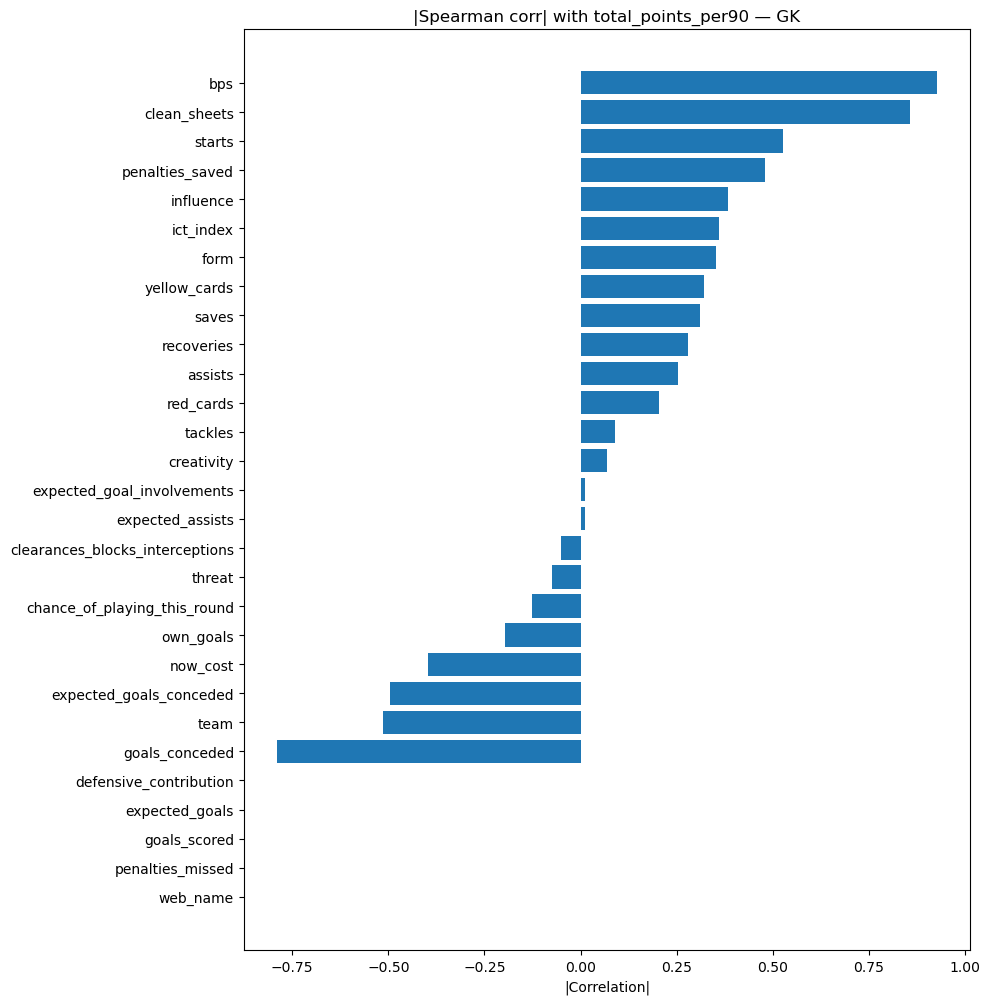

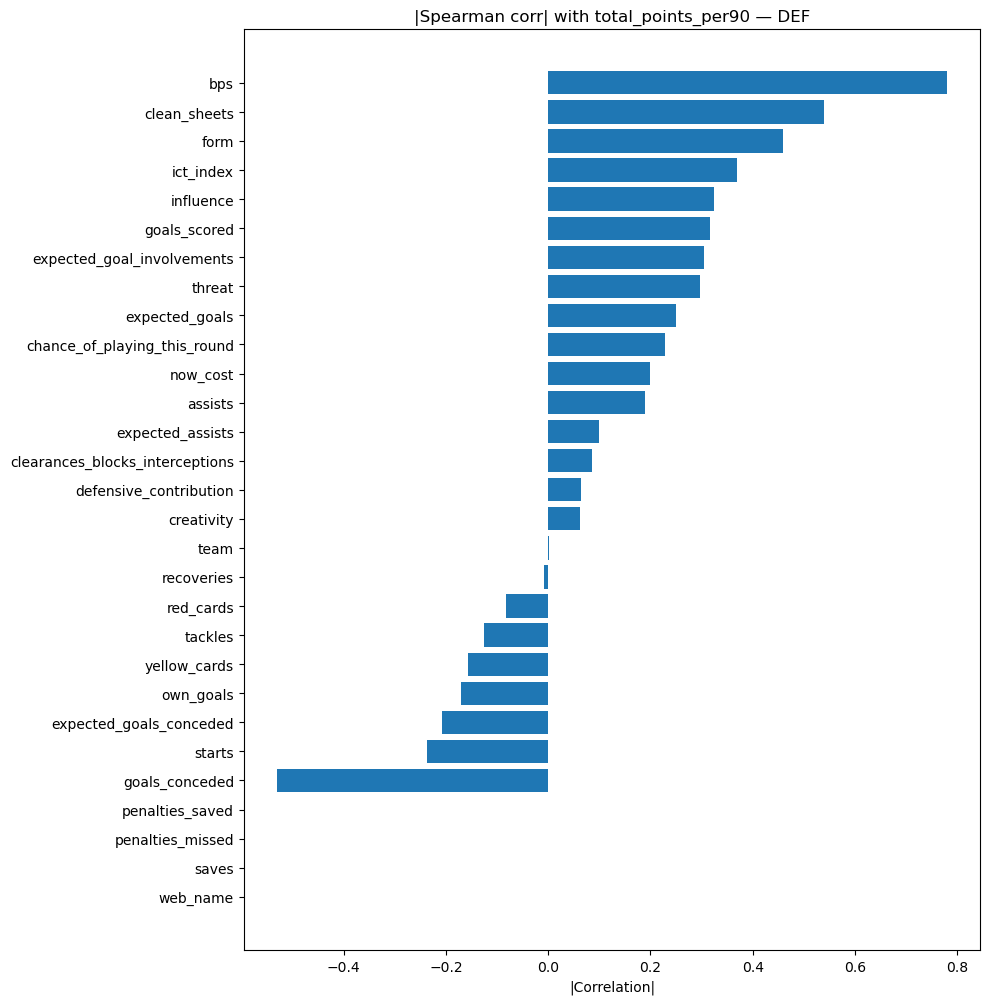

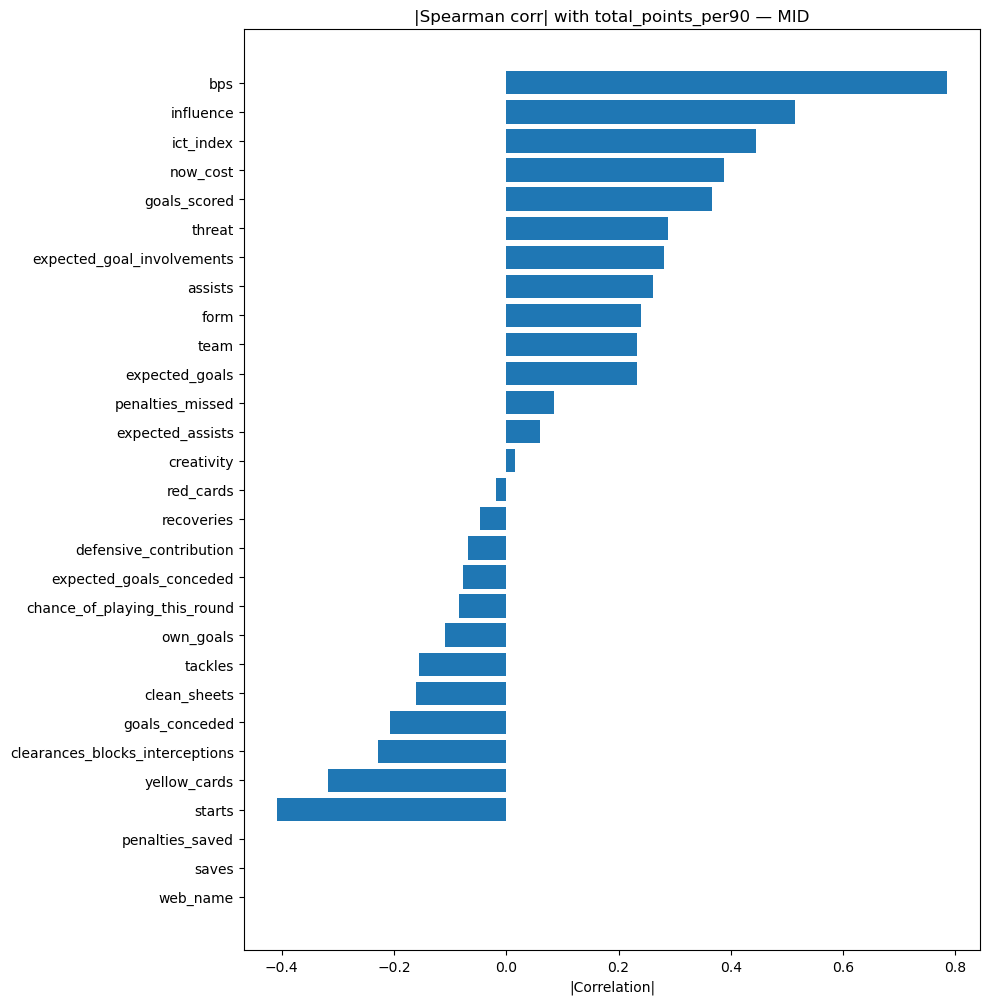

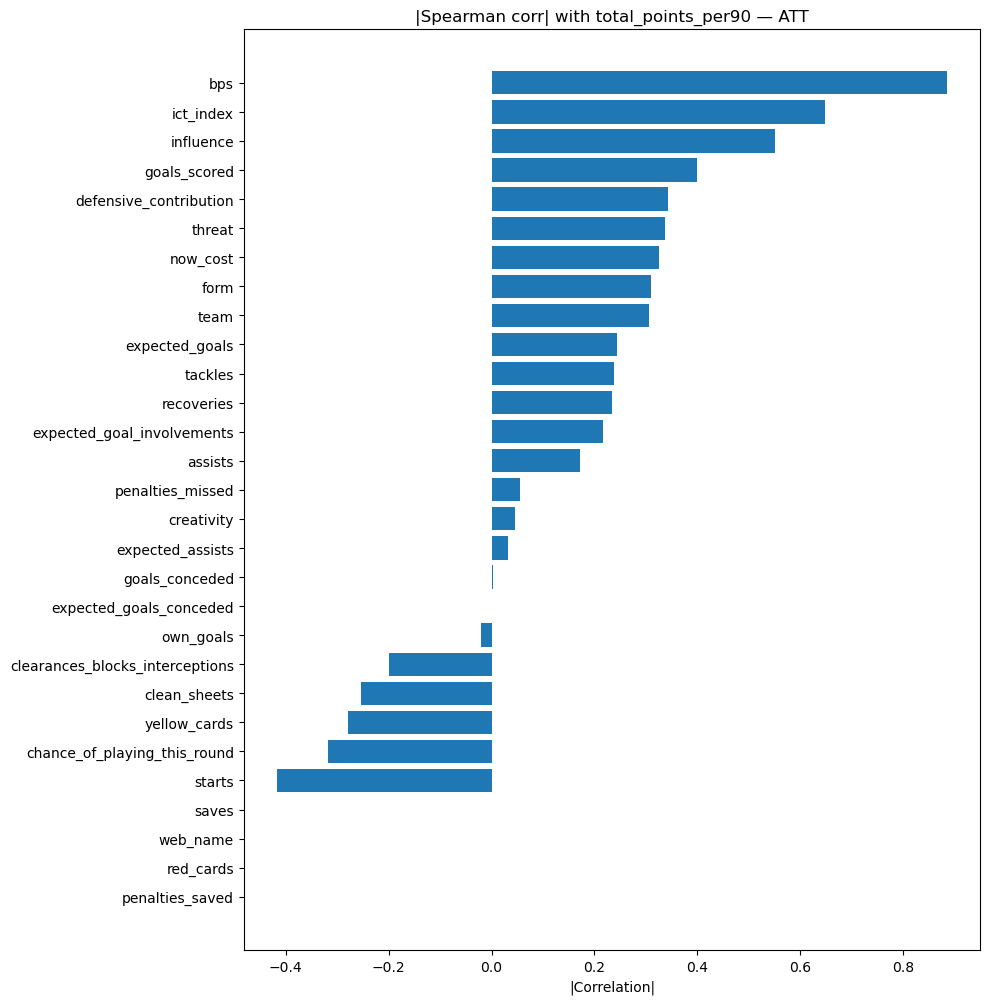

In [234]:
def corr_plots_by_position_per90_abs(
    df: pd.DataFrame,
    group_col: str = "element_type",
    target: str = "total_points",
    minutes_col: str = "minutes",
    positions=("gk", "def", "mid", "att"),
    method: str = "spearman",
):
    d = df.copy()

    for c in d.columns:
        if c != group_col:
            d[c] = pd.to_numeric(d[c], errors="coerce")

    num_cols = d.select_dtypes(include="number").columns
    if target not in num_cols or minutes_col not in num_cols:
        raise ValueError(f"'{target}' and '{minutes_col}' must be numeric columns in df.")

    denom = d[minutes_col].replace(0, np.nan) / 90.0
    per90 = d[num_cols].div(denom, axis=0)
    per90[minutes_col] = d[minutes_col]
    

    features = [c for c in num_cols if c not in (target, minutes_col)]
    corr_df = pd.DataFrame(index=list(positions), columns=features, dtype=float)

    for pos in positions:
        sub = per90.loc[d[group_col] == pos, [target] + features]
        if len(sub) < 2:
            continue

        s = sub.corr(method=method)[target].reindex(features)
    
        s_sorted = s.reindex(s.fillna(-1).sort_values(ascending=False).index).fillna(0)

        plt.figure(figsize=(10, max(4, 0.35 * len(s_sorted))))
        y = np.arange(len(s_sorted))
        plt.barh(y, s_sorted.values)
        plt.yticks(y, s_sorted.index)
        plt.gca().invert_yaxis()
        plt.title(f"|{method.title()} corr| with {target}_per90 — {pos.upper()}")
        plt.xlabel("|Correlation|")
        plt.tight_layout()
        plt.show()

        corr_df.loc[pos] = s

    return corr_df

corr_df = corr_plots_by_position_per90_abs(
    players_data_df,
    group_col="element_type",
    target="total_points",
    minutes_col="minutes",
    method="spearman",
)


## Data Refresh & Player Metadata Extraction

This section refreshes the FPL API data and extracts key player information for the upcoming gameweek predictions. We retrieve fresh player metadata including ID, name, position, team, cost, and injury status.

In [235]:
def make_regressor(model_type="xgb", params=None):
    params = params or {}
    if model_type == "xgb":
        base = dict(
            n_estimators=800,
            learning_rate=0.03,
            max_depth=4,
            subsample=0.8,
            colsample_bytree=0.8,
            reg_lambda=1.0,
            objective="reg:squarederror",
            random_state=42,
        )
        base.update(params)
        return XGBRegressor(**base)
    if model_type == "cat":
        base = dict(
            loss_function="RMSE",
            iterations=2000,
            learning_rate=0.03,
            depth=6,
            l2_leaf_reg=3.0,
            random_seed=42,
            verbose=False,
        )
        base.update(params)
        return CatBoostRegressor(**base)
    raise ValueError("model_type must be 'xgb' or 'cat'")


In [236]:
def get_bootstrap():
    return requests.get("https://fantasy.premierleague.com/api/bootstrap-static/").json()

def get_fixtures_df():
    return pd.DataFrame(requests.get("https://fantasy.premierleague.com/api/fixtures/").json())

fpl_data = get_bootstrap()
fixtures_df = get_fixtures_df()

players_data = fpl_data["elements"]
events_data = fpl_data["events"]
teams_data = fpl_data["teams"]


In [237]:
players_meta_df = pd.DataFrame(players_data)[
    ["id","web_name","element_type","team","now_cost","chance_of_playing_this_round"]
].copy()

players_meta_df["id"] = pd.to_numeric(players_meta_df["id"], errors="coerce").astype(int)
players_meta_df["element_type"] = pd.to_numeric(players_meta_df["element_type"], errors="coerce").astype(int)
players_meta_df["team"] = pd.to_numeric(players_meta_df["team"], errors="coerce").astype(int)
players_meta_df["now_cost"] = pd.to_numeric(players_meta_df["now_cost"], errors="coerce")
players_meta_df["chance_of_playing_this_round"] = pd.to_numeric(players_meta_df["chance_of_playing_this_round"], errors="coerce").fillna(100)

teams_df = pd.DataFrame(teams_data)[["id","short_name"]].copy()
team_name_map = dict(zip(teams_df["id"], teams_df["short_name"]))


In [238]:
def fixtures_long_fdr(fixtures_df):
    f = fixtures_df.loc[
        fixtures_df["event"].notna(),
        ["event","team_h","team_a","team_h_difficulty","team_a_difficulty"],
    ].copy()
    f["event"] = pd.to_numeric(f["event"], errors="coerce").astype(int)

    home = pd.DataFrame(
        {
            "event": f["event"],
            "team": f["team_h"],
            "opponent_team": f["team_a"],
            "was_home": 1,
            "fdr": f["team_h_difficulty"],
        }
    )
    away = pd.DataFrame(
        {
            "event": f["event"],
            "team": f["team_a"],
            "opponent_team": f["team_h"],
            "was_home": 0,
            "fdr": f["team_a_difficulty"],
        }
    )
    out = pd.concat([home, away], ignore_index=True)
    out["team"] = pd.to_numeric(out["team"], errors="coerce").astype(int)
    out["opponent_team"] = pd.to_numeric(out["opponent_team"], errors="coerce").astype(int)
    out["was_home"] = pd.to_numeric(out["was_home"], errors="coerce").astype(int)
    out["fdr"] = pd.to_numeric(out["fdr"], errors="coerce").fillna(3.0)
    return out

def team_event_fdr(fixtures_df):
    f = fixtures_df.loc[
        fixtures_df["event"].notna(),
        ["event","team_h","team_a","team_h_difficulty","team_a_difficulty"],
    ].copy()
    f["event"] = pd.to_numeric(f["event"], errors="coerce").astype(int)

    home = f.rename(
        columns={"team_h":"team","team_a":"opponent","team_h_difficulty":"fdr"}
    )[["team","event","opponent","fdr"]]
    away = f.rename(
        columns={"team_a":"team","team_h":"opponent","team_a_difficulty":"fdr"}
    )[["team","event","opponent","fdr"]]

    long = pd.concat([home, away], ignore_index=True)
    long["team"] = pd.to_numeric(long["team"], errors="coerce").astype(int)
    long["event"] = pd.to_numeric(long["event"], errors="coerce").astype(int)
    long["fdr"] = pd.to_numeric(long["fdr"], errors="coerce").fillna(3.0)

    out = long.groupby(["team","event"], as_index=False).agg(
        fdr=("fdr","mean"),
        games=("fdr","size"),
    )
    out["games"] = pd.to_numeric(out["games"], errors="coerce").fillna(0).astype(int)
    return out

fx_long = fixtures_long_fdr(fixtures_df)
team_event_df = team_event_fdr(fixtures_df)


In [239]:
def get_element_summary(player_id, session=None):
    s = session or requests.Session()
    url = f"https://fantasy.premierleague.com/api/element-summary/{int(player_id)}/"
    return s.get(url).json()

def build_player_gw_history(players_meta_df, fx_long):
    s = requests.Session()
    rows = []
    for pid in players_meta_df["id"].tolist():
        j = get_element_summary(int(pid), session=s)
        h = pd.DataFrame(j.get("history", []))
        if len(h) == 0:
            continue
        h["id"] = int(pid)
        rows.append(h)

    hist = pd.concat(rows, ignore_index=True)

    keep = [
        "id","round","opponent_team","was_home","total_points","minutes",
        "goals_scored","assists","clean_sheets","goals_conceded","saves",
        "penalties_saved",
        "influence","creativity","threat","ict_index","form",
        "expected_goals","expected_assists","expected_goals_conceded",
        "value",
    ]
    keep = [c for c in keep if c in hist.columns]
    hist = hist[keep].copy()

    hist["id"] = pd.to_numeric(hist["id"], errors="coerce").astype(int)

    hist = hist.merge(
        players_meta_df[["id","web_name","element_type","team"]],
        on="id",
        how="left",
    )

    hist["round"] = pd.to_numeric(hist["round"], errors="coerce").astype(int)
    hist["team"] = pd.to_numeric(hist["team"], errors="coerce").astype(int)
    hist["element_type"] = pd.to_numeric(hist["element_type"], errors="coerce").astype(int)
    hist["opponent_team"] = pd.to_numeric(hist["opponent_team"], errors="coerce").astype(int)
    hist["was_home"] = pd.to_numeric(hist["was_home"], errors="coerce").astype(int)

    hist = hist.merge(
        fx_long,
        left_on=["round","team","opponent_team","was_home"],
        right_on=["event","team","opponent_team","was_home"],
        how="left",
    ).drop(columns=["event"])

    hist = hist.rename(columns={"total_points":"gw_points", "value":"now_cost"})
    hist["gw_points"] = pd.to_numeric(hist["gw_points"], errors="coerce")
    hist["now_cost"] = pd.to_numeric(hist["now_cost"], errors="coerce")
    hist["fdr"] = pd.to_numeric(hist["fdr"], errors="coerce").fillna(3.0)

    return hist

player_gw_df = build_player_gw_history(players_meta_df, fx_long)


In [240]:
def add_rolling_features(df, group_col="id", time_col="round", windows=(3,), shift=1, cols=None):
    d = df.copy()
    d[time_col] = pd.to_numeric(d[time_col], errors="coerce")
    d = d.sort_values([group_col, time_col])

    if cols is None:
        cols = [
            "minutes","goals_scored","assists","clean_sheets","goals_conceded","saves",
            "expected_goals","expected_assists","expected_goals_conceded",
            "influence","creativity","threat","ict_index","form",
        ]
    cols = [c for c in cols if c in d.columns]
    for c in cols:
        d[c] = pd.to_numeric(d[c], errors="coerce")

    for w in windows:
        rolled = d.groupby(group_col, sort=False)[cols].rolling(w, min_periods=1).mean()
        if shift:
            rolled = rolled.shift(shift)
        rolled = rolled.reset_index(level=0, drop=True)
        rolled.columns = [f"{c}_r{w}" for c in cols]
        d = pd.concat([d, rolled], axis=1)

    return d

window = 3
train_df = add_rolling_features(player_gw_df, windows=(window,), shift=1)
train_df["round"] = pd.to_numeric(train_df["round"], errors="coerce").astype(int)


In [258]:
def get_target_gw(events, manual=None):
    if manual is not None:
        return int(manual)
    ev = pd.DataFrame(events).copy()
    if "is_next" in ev.columns and (ev["is_next"] == True).any():
        return int(ev.loc[ev["is_next"] == True, "id"].iloc[0])
    if "is_current" in ev.columns and (ev["is_current"] == True).any():
        return int(ev.loc[ev["is_current"] == True, "id"].iloc[0]) + 1
    return int(pd.to_numeric(ev["id"], errors="coerce").max())

target_gw = get_target_gw(events_data)
target_gw

19

In [259]:
def add_rolling_features(df, group_col="id", time_col="round", windows=(3,), shift=1, cols=None):
    d = df.copy()
    d[time_col] = pd.to_numeric(d[time_col], errors="coerce")
    d = d.sort_values([group_col, time_col])

    if cols is None:
        cols = [
            "minutes","goals_scored","assists","clean_sheets","goals_conceded","saves",
            "expected_goals","expected_assists","expected_goals_conceded",
            "influence","creativity","threat","ict_index","form",
        ]
    cols = [c for c in cols if c in d.columns]
    for c in cols:
        d[c] = pd.to_numeric(d[c], errors="coerce")

    for w in windows:
        rolled = d.groupby(group_col, sort=False)[cols].rolling(w, min_periods=1).mean()
        if shift:
            rolled = rolled.shift(shift)
        rolled = rolled.reset_index(level=0, drop=True)
        rolled.columns = [f"{c}_r{w}" for c in cols]
        d = pd.concat([d, rolled], axis=1)

    return d

window = 3
train_df = add_rolling_features(player_gw_df, windows=(window,), shift=1)
train_df["round"] = pd.to_numeric(train_df["round"], errors="coerce").astype(int)


In [260]:
feature_map_gw = {
    1: ["now_cost","fdr","clean_sheets_r3","goals_conceded_r3","saves_r3","expected_goals_conceded_r3","minutes_r3"],
    2: ["now_cost","fdr","clean_sheets_r3","goals_conceded_r3","assists_r3","goals_scored_r3","expected_goals_r3","expected_assists_r3","expected_goals_conceded_r3","minutes_r3"],
    3: ["now_cost","fdr","assists_r3","goals_scored_r3","expected_goals_r3","expected_assists_r3","creativity_r3","threat_r3","influence_r3","minutes_r3"],
    4: ["now_cost","fdr","assists_r3","goals_scored_r3","expected_goals_r3","expected_assists_r3","threat_r3","influence_r3","minutes_r3"],
}


In [261]:
def fit_predict_by_position(
    df,
    feature_map,
    target="gw_points",
    pos_col="element_type",
    pred_col="pred",
    model_type="xgb",
    params=None,
):
    d = df.copy()
    d[pos_col] = pd.to_numeric(d[pos_col], errors="coerce")
    d[target] = pd.to_numeric(d[target], errors="coerce")
    d[pred_col] = np.nan

    models = {}
    for pos, feats in feature_map.items():
        missing = [c for c in feats + [target] if c not in d.columns]
        if missing:
            raise KeyError(f"Missing columns for pos {pos}: {missing}")

        sub = d.loc[d[pos_col].eq(pos), feats + [target]].copy()
        if len(sub) < 2:
            continue

        for c in feats:
            sub[c] = pd.to_numeric(sub[c], errors="coerce")

        sub = sub.dropna(subset=[target])
        if len(sub) < 2:
            continue

        X = sub[feats].fillna(0)
        y = sub[target].to_numpy()

        m = make_regressor(model_type=model_type, params=params)

        if len(sub) < 20:
            if model_type == "cat":
                m.fit(X, y)
            else:
                m.fit(X, y, verbose=False)
        else:
            X_tr, X_va, y_tr, y_va = train_test_split(X, y, test_size=0.2, random_state=42)
            if model_type == "cat":
                m.fit(X_tr, y_tr, eval_set=(X_va, y_va), use_best_model=True, early_stopping_rounds=50)
            else:
                m.fit(X_tr, y_tr, eval_set=[(X_va, y_va)], verbose=False)

        models[pos] = m
        d.loc[sub.index, pred_col] = m.predict(X)

    return d, models

def predict_by_position(df, models, feature_map, pos_col="element_type", pred_col="pred"):
    d = df.copy()
    d[pos_col] = pd.to_numeric(d[pos_col], errors="coerce")
    d[pred_col] = np.nan
    for pos, feats in feature_map.items():
        if pos not in models:
            continue
        sub = d.loc[d[pos_col].eq(pos)]
        if len(sub) == 0:
            continue
        X = sub[feats].apply(pd.to_numeric, errors="coerce").fillna(0)
        d.loc[sub.index, pred_col] = models[pos].predict(X)
    return d


In [262]:
def pick_starting_xi(
    df,
    points_col="gw_score",
    cost_col="now_cost",
    pos_col="element_type",
    team_col="team",
    chance_col="chance_of_playing_this_round",
    min_chance=1,
    budget=81.5,
    pos_limits={1: (1, 1), 2: (3, 5), 3: (3, 5), 4: (1, 3)},
    max_from_team=3,
):
    d = df.copy()

    d[points_col] = pd.to_numeric(d[points_col], errors="coerce")
    d[cost_col] = pd.to_numeric(d[cost_col], errors="coerce")
    d[pos_col] = pd.to_numeric(d[pos_col], errors="coerce")

    if chance_col in d.columns:
        d[chance_col] = pd.to_numeric(d[chance_col], errors="coerce").fillna(100)
    else:
        d[chance_col] = 100

    d = d.dropna(subset=[points_col, cost_col, pos_col, team_col]).reset_index(drop=True)
    d = d.loc[d[chance_col].ge(min_chance)].reset_index(drop=True)

    if len(d) < 11:
        raise ValueError("Not enough available players after filtering.")

    cost_is_tenths = d[cost_col].max() > 25
    costs = d[cost_col].to_numpy(dtype=float)
    B = budget * 10 if cost_is_tenths else float(budget)

    if cost_is_tenths:
        costs = np.round(costs).astype(int)
        B = int(round(B))

    points = d[points_col].to_numpy(dtype=float)
    n = len(d)

    c = -points
    integrality = np.ones(n, dtype=int)
    bounds = Bounds(0, 1)

    rows, lb, ub = [], [], []

    rows.append(np.ones(n)); lb.append(11); ub.append(11)
    rows.append(costs.astype(float)); lb.append(-np.inf); ub.append(B)

    pos_arr = d[pos_col].astype(int).to_numpy()
    for pos, (mn, mx) in pos_limits.items():
        mask = (pos_arr == int(pos)).astype(float)
        rows.append(mask); lb.append(mn); ub.append(mx)

    team_arr = d[team_col].to_numpy()
    for t in pd.unique(team_arr):
        mask = (team_arr == t).astype(float)
        rows.append(mask); lb.append(-np.inf); ub.append(max_from_team)

    A = np.vstack(rows)
    constraints = LinearConstraint(A, lb, ub)

    res = milp(c=c, integrality=integrality, bounds=bounds, constraints=constraints)
    if res.status != 0:
        raise RuntimeError(res.message)

    chosen = res.x > 0.5
    return d.loc[chosen].copy()


In [263]:
def show_xi_pretty_plain(
    xi,
    points_col="gw_score",
    pred_col="pred",
    cost_col="now_cost",
    pos_col="element_type",
    name_col="web_name",
    team_col="team",
    fixture_col="fixture",
):
    d = xi.copy()
    d[points_col] = pd.to_numeric(d[points_col], errors="coerce")
    if pred_col in d.columns:
        d[pred_col] = pd.to_numeric(d[pred_col], errors="coerce")
    d[cost_col] = pd.to_numeric(d[cost_col], errors="coerce")
    d["cost"] = np.where(d[cost_col] > 25, d[cost_col] / 10, d[cost_col])

    pos_map = {1: "GK", 2: "DEF", 3: "MID", 4: "FWD"}
    d["pos"] = pd.to_numeric(d[pos_col], errors="coerce").map(pos_map)

    cap_idx = d[points_col].idxmax()
    d["role"] = ""
    d.loc[cap_idx, "role"] = "C"

    d["pos_order"] = d["pos"].map({"GK": 0, "DEF": 1, "MID": 2, "FWD": 3}).fillna(9).astype(int)

    cols = ["role", name_col, "pos", team_col]
    if fixture_col in d.columns:
        cols += [fixture_col]
    cols += ["cost"]
    if pred_col in d.columns:
        cols += [pred_col]
    cols += [points_col]

    out = d.sort_values(["pos_order", points_col], ascending=[True, False])[cols].copy()
    out["cost"] = out["cost"].round(1)
    if pred_col in out.columns:
        out[pred_col] = out[pred_col].round(2)
    out[points_col] = out[points_col].round(2)

    out = out.rename(
        columns={
            name_col: "player",
            team_col: "team",
            pred_col: "pred_gw_pts",
            points_col: "gw_score",
            fixture_col: "opp",
        }
    )
    return out


In [264]:
model_type = "cat"

train_cut = train_df.loc[train_df["round"] < target_gw].copy()

train_cut_with_preds, models = fit_predict_by_position(
    train_cut,
    feature_map_gw,
    target="gw_points",
    pos_col="element_type",
    pred_col="pred",
    model_type=model_type,
)


In [265]:
state_df = player_gw_df.loc[player_gw_df["round"] < target_gw].copy()
state_df = add_rolling_features(state_df, windows=(window,), shift=0)
state_df = state_df.sort_values(["id", "round"]).groupby("id", as_index=False).tail(1).copy()

roll_cols = [c for c in state_df.columns if c.endswith(f"_r{window}")]
pred_df = state_df[["id", "web_name", "element_type", "team"] + roll_cols].copy()

pred_df = pred_df.merge(
    players_meta_df[["id", "now_cost", "chance_of_playing_this_round"]],
    on="id",
    how="left",
)

te = team_event_df.loc[team_event_df["event"].eq(int(target_gw)), ["team", "fdr", "games"]].copy()
te = te.rename(columns={"fdr": "fdr_1", "games": "games_1"})

pred_df = pred_df.merge(te, on="team", how="left")
pred_df["fdr_1"] = pd.to_numeric(pred_df["fdr_1"], errors="coerce").fillna(3.0)
pred_df["games_1"] = pd.to_numeric(pred_df["games_1"], errors="coerce").fillna(0).astype(int)
pred_df["fdr"] = pred_df["fdr_1"]


In [266]:
fx_gw = fx_long.loc[fx_long["event"].eq(int(target_gw)), ["team", "opponent_team", "was_home"]].copy()
fx_gw["team"] = pd.to_numeric(fx_gw["team"], errors="coerce").astype(int)
fx_gw["opponent_team"] = pd.to_numeric(fx_gw["opponent_team"], errors="coerce").astype(int)
fx_gw["was_home"] = pd.to_numeric(fx_gw["was_home"], errors="coerce").astype(int)

fx_gw["opp_name"] = fx_gw["opponent_team"].map(team_name_map).fillna(fx_gw["opponent_team"].astype(str))
fx_gw["ha"] = np.where(fx_gw["was_home"].eq(1), " (H)", " (A)")
fx_gw["fixture"] = fx_gw["opp_name"].astype(str) + fx_gw["ha"]

fx_team_fixture = fx_gw.groupby("team", as_index=False).agg(
    fixture=("fixture", lambda x: " + ".join(list(x)))
)

pred_df = pred_df.merge(fx_team_fixture, on="team", how="left")
pred_df["team_name"] = pred_df["team"].map(team_name_map).fillna(pred_df["team"].astype(str))


In [ ]:
pred_df = predict_by_position(pred_df, models, feature_map_gw, pos_col="element_type", pred_col="pred")
pred_df["gw_score"] = pd.to_numeric(pred_df["pred"], errors="coerce").fillna(0) * pd.to_numeric(pred_df["games_1"], errors="coerce").fillna(0)


In [ ]:
xi = pick_starting_xi(
    pred_df,
    points_col="gw_score",
    cost_col="now_cost",
    pos_col="element_type",
    team_col="team",
    chance_col="chance_of_playing_this_round",
    min_chance=1,
    budget=81.5,
)



In [272]:
pred_df = predict_by_position(pred_df, models, feature_map_gw, pos_col="element_type", pred_col="pred")

pred_df["gw_score"] = pd.to_numeric(pred_df["pred"], errors="coerce").fillna(0) * pd.to_numeric(pred_df["games_1"], errors="coerce").fillna(0)

xi = pick_starting_xi(
    pred_df,
    points_col="gw_score",
    cost_col="now_cost",
    pos_col="element_type",
    team_col="team",
    chance_col="chance_of_playing_this_round",
    min_chance=1,
    budget=81.5,
)

xi = xi.drop(columns=[c for c in ["team_name","fixture","pred","gw_score","now_cost"] if c in xi.columns]).merge(
    pred_df[["id","team_name","fixture","pred","gw_score","now_cost"]],
    on="id",
    how="left"
)

xi_view = show_xi_pretty_plain(
    xi.rename(columns={"team_name": "team"}),
    points_col="gw_score",
    pred_col="pred",
    cost_col="now_cost",
    pos_col="element_type",
    name_col="web_name",
    team_col="team",
    fixture_col="fixture",
)

print(xi_view.to_string(index=False))
captain = xi_view.loc[xi_view["role"].eq("C"), "player"].iloc[0]
captain


role      player pos team team     opp  cost  pred_gw_pts  gw_score
        A.Becker  GK   12  LIV LEE (H)   5.4         3.94      3.94
       A.Jimenez DEF    4  BOU CHE (A)   4.5         5.79      5.79
         Lacroix DEF    8  CRY FUL (H)   5.2         5.15      5.15
        Hincapie DEF    1  ARS AVL (H)   5.5         4.74      4.74
     Hudson-Odoi MID   16  NFO EVE (H)   5.7         5.72      5.72
           Wirtz MID   12  LIV LEE (H)   8.1         5.67      5.67
           Cunha MID   14  MUN WOL (H)   8.1         5.45      5.45
          Gordon MID   15  NEW BUR (A)   7.4         4.88      4.88
   C        Raúl FWD   10  FUL CRY (A)   6.3         6.09      6.09
         Haaland FWD   13  MCI SUN (A)  15.1         5.95      5.95
         Ekitiké FWD   12  LIV LEE (H)   9.1         5.76      5.76


'Raúl'

## Walk-Forward Backtest

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
def make_regressor(model_type="xgb", params=None):
    params = params or {}
    if model_type == "xgb":
        base = dict(
            n_estimators=300,
            learning_rate=0.05,
            max_depth=4,
            subsample=0.8,
            colsample_bytree=0.8,
            reg_lambda=1.0,
            objective="reg:squarederror",
            random_state=42,
        )
        base.update(params)
        return XGBRegressor(**base)
    if model_type == "cat":
        base = dict(
            loss_function="RMSE",
            iterations=1500,
            learning_rate=0.05,
            depth=6,
            l2_leaf_reg=3.0,
            random_seed=42,
            verbose=False,
        )
        base.update(params)
        return CatBoostRegressor(**base)
    raise ValueError("model_type must be 'xgb' or 'cat'")

def fit_models_by_position(df, feature_map, target="gw_points", pos_col="element_type", model_type="xgb", params=None, min_rows=50):
    d = df.copy()
    d[pos_col] = pd.to_numeric(d[pos_col], errors="coerce")
    d[target] = pd.to_numeric(d[target], errors="coerce")

    models = {}
    for pos, feats in feature_map.items():
        sub = d.loc[d[pos_col].eq(pos), feats + [target]].copy()
        sub = sub.dropna(subset=[target])
        if len(sub) < min_rows:
            continue

        X = sub[feats].apply(pd.to_numeric, errors="coerce").fillna(0)
        y = sub[target].to_numpy()

        X_tr, X_va, y_tr, y_va = train_test_split(X, y, test_size=0.2, random_state=42)

        m = make_regressor(model_type=model_type, params=params)

        if model_type == "cat":
            m.fit(X_tr, y_tr, eval_set=(X_va, y_va), use_best_model=True, early_stopping_rounds=50)
        else:
            m.fit(X_tr, y_tr, eval_set=[(X_va, y_va)], verbose=False)

        models[pos] = m

    return models

def predict_by_position(
    pred_df,
    models,
    feature_map,
    pos_col="element_type",
    pred_col="pred",
):
    d = pred_df.copy()
    d[pos_col] = pd.to_numeric(d[pos_col], errors="coerce")
    d[pred_col] = np.nan

    for pos, feats in feature_map.items():
        if pos not in models:
            continue
        sub = d.loc[d[pos_col].eq(pos)]
        if len(sub) == 0:
            continue
        X = sub[feats].apply(pd.to_numeric, errors="coerce").fillna(0)
        d.loc[sub.index, pred_col] = models[pos].predict(X)

    return d


In [ ]:
def team_event_fdr(fixtures_df):
    f = fixtures_df.loc[fixtures_df["event"].notna(), ["event","team_h","team_a","team_h_difficulty","team_a_difficulty"]].copy()
    f["event"] = pd.to_numeric(f["event"], errors="coerce").astype(int)

    home = f.rename(columns={"team_h":"team","team_a":"opponent","team_h_difficulty":"fdr"})[["team","event","opponent","fdr"]]
    away = f.rename(columns={"team_a":"team","team_h":"opponent","team_a_difficulty":"fdr"})[["team","event","opponent","fdr"]]

    long = pd.concat([home, away], ignore_index=True)
    out = long.groupby(["team","event"], as_index=False).agg(
        fdr=("fdr","mean"),
        games=("fdr","size")
    )
    out["fdr"] = pd.to_numeric(out["fdr"], errors="coerce").fillna(3.0)
    out["games"] = pd.to_numeric(out["games"], errors="coerce").fillna(0).astype(int)
    return out

team_event_df = team_event_fdr(fixtures_df)


In [ ]:
def make_pred_frame_for_gw(player_gw_df, team_event_df, gw, window=3):
    base = player_gw_df.loc[pd.to_numeric(player_gw_df["round"], errors="coerce").astype(int) < int(gw)].copy()
    base = add_rolling_features(base, windows=(window,), shift=0)

    last = base.sort_values(["id","round"]).groupby("id", as_index=False).tail(1).copy()
    roll_cols = [c for c in last.columns if c.endswith(f"_r{window}")]

    pred_df = last[["id","web_name","element_type","team","now_cost"] + roll_cols].copy()

    te = team_event_df.loc[team_event_df["event"].eq(int(gw)), ["team","fdr","games"]].copy()
    te = te.rename(columns={"fdr":"fdr_1","games":"games_1"})
    pred_df = pred_df.merge(te, on="team", how="left")

    pred_df["fdr_1"] = pd.to_numeric(pred_df["fdr_1"], errors="coerce").fillna(3.0)
    pred_df["games_1"] = pd.to_numeric(pred_df["games_1"], errors="coerce").fillna(0).astype(int)

    pred_df["fdr"] = pred_df["fdr_1"]
    return pred_df

def actual_points_by_player_gw(player_gw_df, gw):
    x = player_gw_df.loc[pd.to_numeric(player_gw_df["round"], errors="coerce").astype(int).eq(int(gw)), ["id","gw_points"]].copy()
    x["gw_points"] = pd.to_numeric(x["gw_points"], errors="coerce").fillna(0)
    return x.groupby("id", as_index=False).agg(gw_points=("gw_points","sum"))

def xi_actual_points(player_gw_df, xi, gw):
    act = actual_points_by_player_gw(player_gw_df, gw)
    z = xi.merge(act, on="id", how="left")
    return float(pd.to_numeric(z["gw_points"], errors="coerce").fillna(0).sum())


In [ ]:
def backtest_model_vs_avg_entry(
    model_type,
    player_gw_df,
    train_df,
    feature_map,
    fixtures_df,
    team_event_df,
    events_data,
    start_gw=2,
    end_gw=None,
    window=3,
    budget=81.5,
    model_params=None,
):
    ev = pd.DataFrame(events_data)[["id","average_entry_score"]].copy()
    ev["id"] = pd.to_numeric(ev["id"], errors="coerce").astype(int)
    ev["average_entry_score"] = pd.to_numeric(ev["average_entry_score"], errors="coerce")
    avg_map = dict(zip(ev["id"], ev["average_entry_score"]))

    if end_gw is None:
        end_gw = int(pd.to_numeric(player_gw_df["round"], errors="coerce").max())

    rows = []
    for gw in range(int(start_gw), int(end_gw) + 1):
        baseline = avg_map.get(gw, np.nan)
        if pd.isna(baseline) or baseline <= 0:
            continue

        tr = train_df.loc[pd.to_numeric(train_df["round"], errors="coerce").astype(int) < int(gw)].copy()
        if len(tr) < 500:
            continue

        models = fit_models_by_position(
            tr, feature_map, target="gw_points", pos_col="element_type",
            model_type=model_type, params=model_params
        )

        pred_df = make_pred_frame_for_gw(player_gw_df, team_event_df, gw, window=window)
        pred_df = predict_by_position(pred_df, models, feature_map, pos_col="element_type", pred_col="pred")
        pred_df["gw_score"] = pd.to_numeric(pred_df["pred"], errors="coerce").fillna(0) * pd.to_numeric(pred_df["games_1"], errors="coerce").fillna(0)

        xi = pick_starting_xi(pred_df, points_col="gw_score", budget=budget)
        xi_act = xi_actual_points(player_gw_df, xi, gw)

        rows.append({
            "gw": gw,
            "model": model_type,
            "xi_actual": xi_act,
            "avg_entry_score": float(baseline),
            "diff_vs_avg_entry": xi_act - float(baseline),
        })

    return pd.DataFrame(rows)

start_gw = 2
end_gw = int(pd.to_numeric(player_gw_df["round"], errors="coerce").max())
window = 3

progress_xgb = backtest_model_vs_avg_entry(
    "xgb",
    player_gw_df=player_gw_df,
    train_df=train_df,
    feature_map=feature_map_gw,
    fixtures_df=fixtures_df,
    team_event_df=team_event_df,
    events_data=events_data,
    start_gw=start_gw,
    end_gw=end_gw,
    window=window,
    budget=81.5
)

progress_cat = backtest_model_vs_avg_entry(
    "cat",
    player_gw_df=player_gw_df,
    train_df=train_df,
    feature_map=feature_map_gw,
    fixtures_df=fixtures_df,
    team_event_df=team_event_df,
    events_data=events_data,
    start_gw=start_gw,
    end_gw=end_gw,
    window=window,
    budget=81.5
)

progress_all = pd.concat([progress_xgb, progress_cat], ignore_index=True)
progress_all.head()


In [ ]:
pivot = progress_all.pivot(index="gw", columns="model", values="diff_vs_avg_entry").dropna()

wins_xgb = int((pivot["xgb"] > pivot["cat"]).sum()) if {"xgb","cat"}.issubset(pivot.columns) else np.nan
wins_cat = int((pivot["cat"] > pivot["xgb"]).sum()) if {"xgb","cat"}.issubset(pivot.columns) else np.nan

summary = pd.DataFrame({
    "model": ["xgb","cat"],
    "gws_tested": [len(progress_xgb), len(progress_cat)],
    "mean_diff": [progress_xgb["diff_vs_avg_entry"].mean(), progress_cat["diff_vs_avg_entry"].mean()],
    "median_diff": [progress_xgb["diff_vs_avg_entry"].median(), progress_cat["diff_vs_avg_entry"].median()],
    "wins_vs_other": [wins_xgb, wins_cat],
})
summary


,model,gws_tested,mean_diff,median_diff,wins_vs_other
0,xgb,17,-2.764706,-2.0,9
1,cat,17,-2.176471,-2.0,8


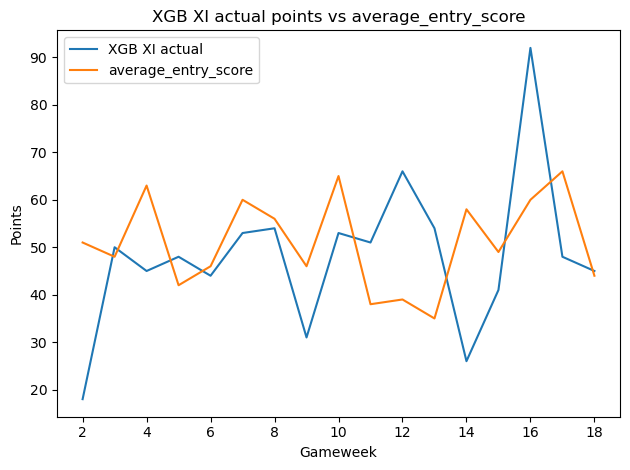

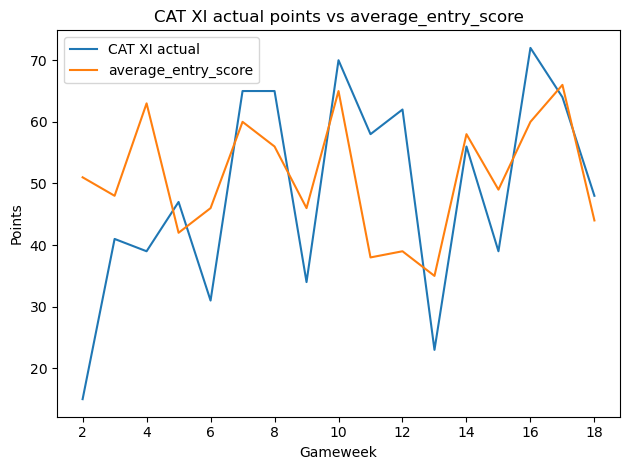

In [ ]:
m1 = "xgb"
m2 = "cat"
plt.figure()
dd = progress_all.loc[progress_all["model"].eq(m1)].sort_values("gw")
if len(dd):
    plt.plot(dd["gw"], dd["xi_actual"], label=f"{m1.upper()} XI actual")
if len(progress_all):
    base = progress_all.drop_duplicates("gw").sort_values("gw")
    plt.plot(base["gw"], base["avg_entry_score"], label="average_entry_score")
plt.xlabel("Gameweek")
plt.ylabel("Points")
plt.title("XGB XI actual points vs average_entry_score")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure()
dd = progress_all.loc[progress_all["model"].eq(m2)].sort_values("gw")
if len(dd):
    plt.plot(dd["gw"], dd["xi_actual"], label=f"{m2.upper()} XI actual")
if len(progress_all):
    base = progress_all.drop_duplicates("gw").sort_values("gw")
    plt.plot(base["gw"], base["avg_entry_score"], label="average_entry_score")
plt.xlabel("Gameweek")
plt.ylabel("Points")
plt.title("CAT XI actual points vs average_entry_score")
plt.legend()
plt.tight_layout()
plt.show()